---
title: "Classification of Podium Finishing at HKJC using Multinomial Naive Bayes"
---
In this section, we will be generating a Multinomial Naive Bayes Model that attempts to predict whether a horse finishes on the podium (1st place, 2nd place, or 3rd place) in any given race. Predicting podium finishes makes up a giant portion of any horse racing betting market and the HKJC betting market is no exception. For this analysis, conducted using Python, we are going to be looking at how we can we use some categorical/discrete numerical variables in our dataset as determinants of podium finishing. As discussed in the Naive Bayes Intro section, Naive Bayes has a Multinomial Classifier algorithim that is suited for handling a feature set that is all discrete, numerical variables. We are going to be "dummy coding" our categorical variables as discrete, numerical variables in order to apply the Multinomial NB algorithim (see this Stack Exchange [link](https://stats.stackexchange.com/questions/93928/naive-bayes-continuous-and-categorical-predictors]) for more information on why we are able to dummy code our categorical variables and still use Multinomial NB). It is through this analysis that we will be able to see if a horse's attributes like sex, color, and import type and also naturally discrete variables like draw, rating, and days of rest are able to succesfully classify podium finishers.

This section will be completed using Python.

# Data Preparation
We will begin this analysis by prepping and formatting our data, so that it may be properly read by our algorithim.

In [85]:
import pandas as pd
import numpy as np
import scipy
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [42]:
# Reading in our data
horses = pd.read_csv('../../../data/01-modified-data/horses.clean.csv')
perf = pd.read_csv('../../../data/01-modified-data/perf.clean.no.error.csv')

/tmp/ipykernel_153880/915142976.py:3: DtypeWarning: Columns (10,18,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  perf = pd.read_csv('../../../data/01-modified-data/perf.clean.no.error.csv')


We are now going to join horse attributes from the horses data set with the performance dataset.

In [43]:
# Need to join color, sex, and import type with perf data.
perf_clean = pd.merge(perf,horses[["horse_id","colour","sex","import_type"]],on="horse_id",how = "inner")

Now we are going to create a variable "podium" that is equal to 1 if a horse placed in the top 3 and 0 if it did not. This variable is what we will be trying to classify with a Categorical Naive Bayes Classifier.

In [44]:
perf_clean['podium'] = np.nan
perf_clean['podium'] = np.where(perf_clean['final_placing'].isin([1, 2, 3]), 1, 0)

Now we will create a subset of data with our features of interest. Our features of interest are all of our categorical variables.

In [71]:
perf_cat_classifier = perf_clean[['podium','colour','sex','import_type','draw','rating','days_between']]
perf_cat_classifier = perf_cat_classifier.dropna()

With our feature set, we must now dummy code our categorical features into numbers in order for our Naive Bayes algorithim to be able to handle the features. We will be using sklearn's preproccesing package.

In [72]:
from sklearn import preprocessing

perf_classifier_encode = perf_cat_classifier

perf_classifier_encode = perf_classifier_encode.apply(preprocessing.LabelEncoder().fit_transform)
perf_classifier_encode = pd.DataFrame(perf_classifier_encode)

In [73]:
perf_classifier_encode.head(10)

,podium,colour,sex,import_type,draw,rating,days_between
0,0,0,3,1,5,72,22
1,0,0,3,1,0,71,24
2,0,0,3,1,0,67,246
3,0,0,3,1,8,66,67
4,0,0,3,1,13,64,135
5,0,0,3,1,6,62,11
6,0,0,3,1,13,60,20
7,1,0,3,1,3,58,11
8,1,2,3,1,6,76,13
9,1,2,3,1,3,77,23


# Feature Selection for Multinomial Naive Bayes

Now we are going to perform a feature selection process, so that we are using an optimal feature set for our NB classifier. We do not want to be including features in our classifier that detract from the effectivness of said classifier. We will now go ahead and define our feature set, which is all categorical and discrete numerical variables, and dependent variable, y (podium).

In [74]:
x = np.array(perf_classifier_encode.loc[:, perf_classifier_encode.columns != 'podium'])
y = np.array([perf_classifier_encode['podium']])
y = y.transpose()

We will now go ahead and create a training, validation, and test set out of our data. The first 10 random indicies for our training, validation, and test splits are printed below

In [75]:
import random
random.seed(100)
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
cut2 = int((N - cut)/2 + cut)
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
validate_index = l[cut:cut2] # 10% of shuffled list
test_index = l[cut2:] # 10% of shuffled list

print(train_index[0:10])
print(validate_index[0:10])
print(test_index[0:10])

[184317, 35142, 156934, 211440, 254189, 120768, 50992, 187576, 149295, 114769]
[49235, 119729, 212655, 217398, 47295, 42808, 179741, 243627, 1139, 231747]
[136214, 43047, 18090, 61177, 180581, 210039, 92160, 17150, 81449, 181451]


We will now go ahead and fit our model and find the precision of the model on both the training and test sets, along with the time it takes to evaluate the models. This fitting process should be fairly computationally inexpensive because our feature set is small, but it is still a good idea to check computing time with any model fitting. Precision is our metric of interest over any of the other evaluation metrics.

The reasoning for wanting to maximize precision over any of the other models is that precision tells us out of all the horse podium finishers we are predicting, we are predicting X percentage correct. In the betting world, being right is what makes you money. Measures like accuracy and negative predictive value, which help tell us how well our model is predicting horses that do NOT finish on the podium, are not helpful to us in a betting scenario. With a measure like sensitivity (recall), we are quantifying out of all the possible podium finishers, we are succesfully predicting X percentage of the total podium finisher pool. This measure is not totally unhelpful as it tells us the extent to which we are maximizing potential betting opportunities, but for the sake of this analysis, we care more about being right than maximizing potential betting opportunities, hence precision was our measure of interest for evaluating all of our models.

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score
import time

# Defining a function that generates a NB model
def train_MNB_model(X,Y,i_print=False):

    if(i_print):
        print(X.shape,Y.shape)

    #SPLIT
    x_train=X[train_index]
    y_train=Y[train_index].flatten()

    x_test=X[test_index]
    y_test=Y[test_index].flatten()

    # INITIALIZE MODEL 
    model = MultinomialNB()

    # TRAIN MODEL 
    start = time.process_time()
    model.fit(x_train,y_train)
    time_train=time.process_time() - start

    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    start = time.process_time()
    yp_train = model.predict(x_train)
    yp_test = model.predict(x_test)
    time_eval=time.process_time() - start

    prec_train= precision_score(y_train, yp_train)*100
    prec_test= precision_score(y_test, yp_test)*100

    if(i_print):
        print(prec_train,prec_test,time_train,time_eval)

    return (prec_train,prec_test,time_train,time_eval)


#TEST
print(type(x),type(y))
print(x.shape,y.shape)
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(256936, 6) (256936, 1)
(256936, 6) (256936, 1)
27.903000561218498 27.27272727272727 0.051897600000017974 0.13326610000001438


With our initial model, we see a test precision of around 27%. Also, as expected, computational time is very low for both. Now, we will go ahead and analyze how each of the features impact our classifier, allowing us to determine if we should remove any features.

We will now peform an analysis to identify a best subset of features that gives us the best test precision. We will use the itertools package.

In [79]:
import itertools
best_prec = 0
m = x.shape[1]

for i in range(1, m + 1):
          subset = itertools.combinations(range(m),i)

          for j in subset:
               x_subset = x[:,j]
               (prec_train,prec_test,time_train,time_eval)=train_MNB_model(x_subset,y,i_print=False)

               if prec_test > best_prec:
                    best_prec = prec_test
                    best_subset = x_subset

print(best_subset)

/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcarswell/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classifica

[[ 3  1  5 72]
 [ 3  1  0 71]
 [ 3  1  0 67]
 ...
 [ 3  3  1 58]
 [ 3  3  4 55]
 [ 3  3  6 60]]


Our output optimal set of features that maximizes precision is going to be Import Type, Draw, and Rating. We will now only be proceeding with these features.

# Fitting a Final, "Optimal" NB Model
We will now use our subset of features to fit a final NB model. Our training model, consisting of the optimal feature set, will take a split of test data from the original dataset in order to give the model "unseen" data with classfication labels we already know, so that we can develop accurate metrics surrounding the performance of our model.

In [80]:
x = np.array(perf_classifier_encode[['import_type','draw','rating']])
y = np.array([perf_classifier_encode['podium']])
y = y.transpose()

In [81]:
import random
N=x.shape[0]
l = [*range(N)]     # indices
cut = int(0.8 * N) #80% of the list
cut2 = int((N - cut)/2 + cut)
random.shuffle(l)   # randomize
train_index = l[:cut] # first 80% of shuffled list
validate_index = l[cut:cut2] # 10% of shuffled list
test_index = l[cut2:] # 10% of shuffled list

In [82]:
(acc_train,acc_test,time_train,time_eval)=train_MNB_model(x,y,i_print=True)

(256936, 3) (256936, 1)
33.54893138357705 35.189873417721515 0.04381219999999075 0.20717200000001412


We can see above that our model has a train precision of 33.5% test precision around 35% which is fairly decent. Because both our training and test precisions are very close in magnitude, with the test precision being slightly larger, we can conclude that our model is definitely not overfit as the test precision would be much lower if this were the case. There might be the argument that our model underfits the data because our test precision is so close to the train precision, and as you will see later, our F-1 score is pretty abysmal. We explore this idea in a little bit.

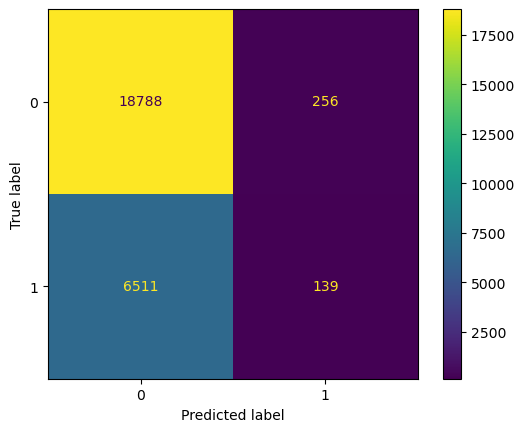

In [83]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import metrics
x_train=x[train_index]
y_train=y[train_index].flatten()

x_test=x[test_index]
y_test=y[test_index].flatten()

clf = MultinomialNB()
clf.fit(x_train,y_train)

yp_test = clf.predict(x_test)
cm = confusion_matrix(y_test, yp_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [84]:
Accuracy = metrics.accuracy_score(y_test, yp_test)
Precision = metrics.precision_score(y_test, yp_test)
Sensitivity = metrics.recall_score(y_test, yp_test)
Specificity = metrics.recall_score(y_test, yp_test,pos_label=0)
F1_score = metrics.f1_score(y_test, yp_test)
print("Accuracy:",Accuracy*100)
print("Precision:", Precision*100)
print("Sensitivity:",Sensitivity*100)
print("Specificity:",Specificity*100)
print("F1 Score:",F1_score*100)

Accuracy: 73.66311201058613
Precision: 35.189873417721515
Sensitivity: 2.0902255639097747
Specificity: 98.65574459147238
F1 Score: 3.946061036195883


 We can notice a few things. First of all, our model is about 73% accurate which is very strong. At the surface level, our precision is also fairly strong at around 35%. Of the horse podium finishers predicted, our model predicts correctly predicts them as podium finishers 35% of the time. HOWEVER, our confusion matrix shows that our model only predicted 139 out of the over 20,0000 observations as correctly positive podium finishers. We can see in the confusion matrix that the model is REALLY good at predicting non-podium finishers with a specificity of around 99%. This characteristic is not really impressive in practicality, however, as we are really just interested in predicting horse podium finishers. Resultantly, our ability in predicting positive results is very low, with an EXTREMELY low sensitity score. Our F-1 score is also VERY low, showing that this model is overall not very effective at all for predicting horse racing podium finishes. This characteristic is also an indication that our model is very underfitted as we are not capturing all neccessary patterns and behaviors neccessary for correctly prediciting podium finishes.

# Conclusion
Overall, our model is not a fantastic overall tool for predicting horse podium finishers. What is a valuable takeaway from this exercise, however, is we can very strongly observe what characteristics drive a horse to NOT finsh on the podium. A horse's attributes like color and sex (which delineate what type of horse we are observing) really do not have any impact on the probability a horse has a podium finish. A horse's import type can, however, be used to help inform if a horse will likely not finish on the podium. Rating and draw are the most important features here. Our model is able to show us that given a horse's draw and rating, we can discount its likelihood to finish on the podium if its draw and rating are below a certain threshold. While this threshold is not clearly defined yet, this phenomena does allow us to understand that draw and rating will be important features as we continue to try and predict horse performance with more advanced statistical methods. These findings will be reported in the final conclusive report generated for this project, along with being used as the basis for much of the feature selection we use as we go forth developing more advanced models in this project, especially as we try to increase precision scores under the decision tree section.